# Create A Pitch Framing Model Using XGBoost

In [70]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
df17 = pd.read_csv('/Users/reececalvin/Baseball/statcast_2017.csv')
df18 = pd.read_csv('/Users/reececalvin/Baseball/statcast_2018.csv')
df19 = pd.read_csv('/Users/reececalvin/Baseball/statcast_2019.csv')
df20 = pd.read_csv('/Users/reececalvin/Baseball/statcast_2020.csv')
df21 = pd.read_csv('/Users/reececalvin/Baseball/2021_season.csv')
df22 = pd.read_csv('/Users/reececalvin/Baseball/2022_season.csv')
df23 = pd.read_csv('/Users/reececalvin/Baseball/2023_season.csv')

df_train = pd.concat([df17, df18, df19, df20, df21])

### Isolate Called Pitches and Create a Called Strike Column

In [149]:
df_train['called_strike'] = df_train['description'] == 'called_strike'
called_train = df_train[df_train['description'].isin(['called_strike', 'ball'])].dropna(subset=['plate_x', 'plate_z', 'balls', 'strikes', 'stand', 'p_throws'])

df22['called_strike'] = df22['description'] == 'called_strike'
called22 = df22[df22['description'].isin(['called_strike', 'ball'])].dropna(subset=['plate_x', 'plate_z', 'balls', 'strikes', 'stand', 'p_throws'])

df23['called_strike'] = df23['description'] == 'called_strike'
called23 = df23[df22['description'].isin(['called_strike', 'ball'])].dropna(subset=['plate_x', 'plate_z', 'balls', 'strikes', 'stand', 'p_throws'])

# Set stand and p_throws to 0 for left and 1 for right
called_train['stand'] = called_train['stand'].map({'L': 0, 'R': 1})
called_train['p_throws'] = called_train['p_throws'].map({'L': 0, 'R': 1})

called22['stand'] = called22['stand'].map({'L': 0, 'R': 1})
called22['p_throws'] = called22['p_throws'].map({'L': 0, 'R': 1})

called23['stand'] = called23['stand'].map({'L': 0, 'R': 1})
called23['p_throws'] = called23['p_throws'].map({'L': 0, 'R': 1})

/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_86807/3172833624.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  called23 = df23[df22['description'].isin(['called_strike', 'ball'])].dropna(subset=['plate_x', 'plate_z', 'balls', 'strikes', 'stand', 'p_throws'])


## Create a Train and Test Set using the 2021 Season

In [150]:
X_train, X_test, y_train, y_test = train_test_split(called_train[['plate_x', 'plate_z', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'release_speed', 'stand', 'p_throws']], called_train['called_strike'], test_size=0.33)

## Create a XGBoost Model and Train on 2021 Data


In [151]:
# Define Parameters for XGBoost and Train the Model
param = {'max_depth': 5, 'eta': 1, 'objective': 'binary:logistic'}
framing_model = xgb.XGBClassifier(**param)

framing_model.fit(X_train, y_train)
framing_model.score(X_test, y_test)

0.9237048902216821

## Plot the Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

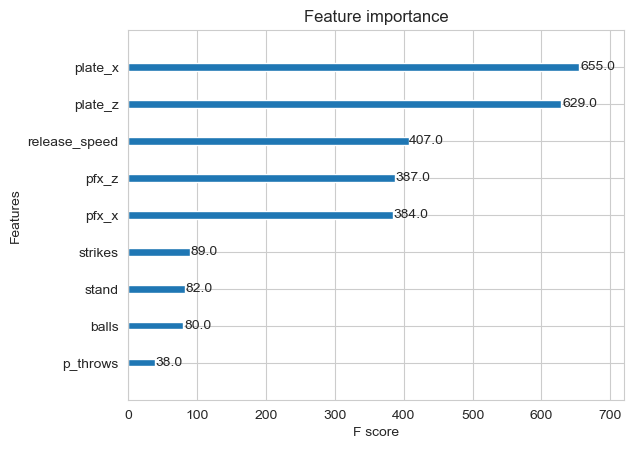

In [152]:
xgb.plot_importance(framing_model)

## Find Shadow Zone

In [155]:
called22['xStrike'] = framing_model.predict_proba(called22[['plate_x', 'plate_z', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'release_speed', 'stand', 'p_throws']])[:, 0]

called23['xStrike'] = framing_model.predict_proba(called23[['plate_x', 'plate_z', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'release_speed', 'stand', 'p_throws']])[:, 0]

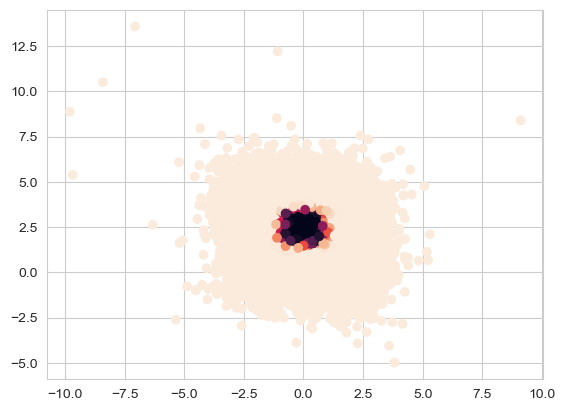

In [157]:
plt.scatter(X_test['plate_x'], X_test['plate_z'], c=framing_model.predict_proba(X_test)[:, 0])
plt.show()

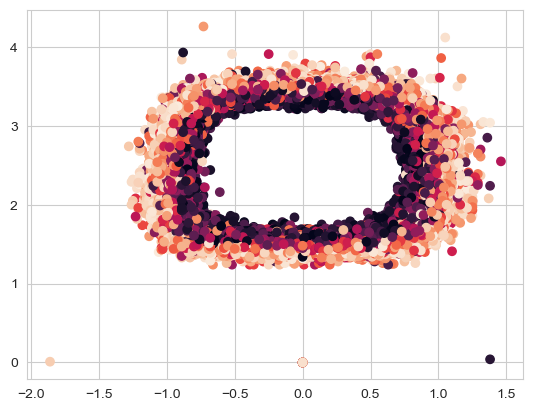

In [160]:
X_test['xStrike'] = framing_model.predict_proba(X_test[['plate_x', 'plate_z', 'balls', 'strikes', 'pfx_x', 'pfx_z', 'release_speed', 'stand', 'p_throws']])[:, 0]

sz = X_test[(X_test['xStrike'] > .3) & (X_test['xStrike'] < .75)]
plt.scatter(sz['plate_x'], sz['plate_z'], c=sz['xStrike'])
plt.show()

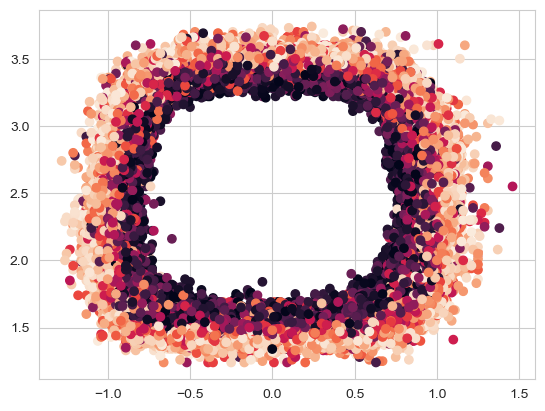

In [191]:
sz = sz[(sz['xStrike'] > .3) & (sz['xStrike'] < .75) & (sz['plate_z'] > 1) & (sz['plate_z'] < 3.75)]
plt.scatter(sz['plate_x'], sz['plate_z'], c=sz['xStrike'])
plt.show()

In [161]:
sz22 = called22[(called22['xStrike'] > .3) & (called22['xStrike'] < .75) & (called22['plate_z'] > 1) & (called22['plate_z'] < 3.75)]

sz23 = called23[(called23['xStrike'] > .3) & (called23['xStrike'] < .75) & (called23['plate_z'] > 1) & (called23['plate_z'] < 3.75)]

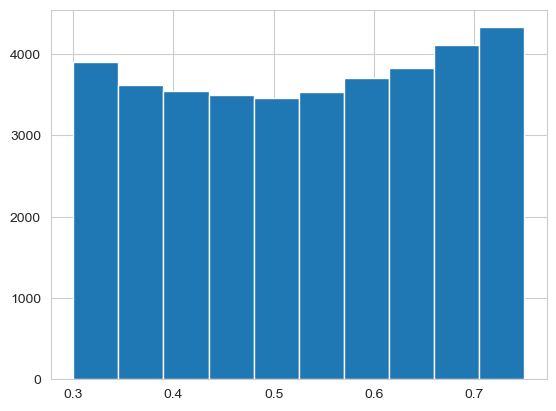

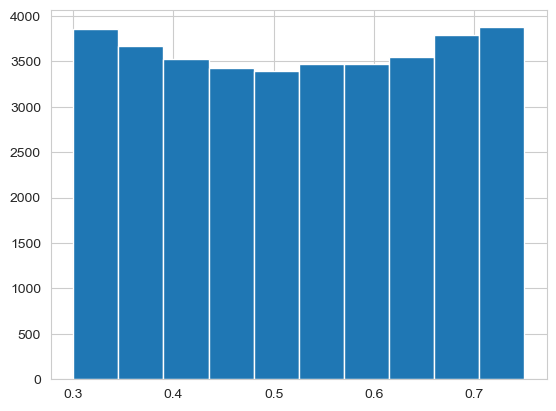

In [162]:
plt.hist(sz22['xStrike'], bins=10)
plt.show()

plt.hist(sz23['xStrike'], bins=10)
plt.show()

In [192]:
sz22['Framing Runs'] = (sz22['called_strike'] - sz22['xStrike']) * .125
sz23['Framing Runs'] = (sz23['called_strike'] - sz23['xStrike']) * .125

framing22 = sz22.groupby('fielder_2').agg({'Framing Runs': 'sum', 'balls':'count', 'xStrike': 'sum', 'called_strike': 'sum'})
framing23 = sz23.groupby('fielder_2').agg({'Framing Runs': 'sum', 'balls':'count', 'xStrike': 'sum', 'called_strike': 'sum'})

framing22['Runs/100'] = framing22['Framing Runs'] / framing22['balls'] * 100
framing23['Runs/100'] = framing23['Framing Runs'] / framing23['balls'] * 100

framing22['Percent Saved'] = framing22['called_strike'] / framing22['xStrike']
framing23['Percent Saved'] = framing23['called_strike'] / framing23['xStrike']

framing22_qual = framing22[framing22['balls'] > 200]
framing23_qual = framing23[framing23['balls'] > 200]

/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_86807/477464773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sz22['Framing Runs'] = (sz22['called_strike'] - sz22['xStrike']) * .125
/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_86807/477464773.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sz23['Framing Runs'] = (sz23['called_strike'] - sz23['xStrike']) * .125


In [193]:
framing23_qual['Runs/100 2022'] = framing22_qual['Runs/100']
framing23_qual['Runs/100 2023'] = framing23_qual['Runs/100']

framing23_qual = framing23_qual.dropna(subset=['Runs/100 2023', 'Runs/100 2022'])

/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_86807/3729880229.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  framing23_qual['Runs/100 2022'] = framing22_qual['Runs/100']
/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_86807/3729880229.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  framing23_qual['Runs/100 2023'] = framing23_qual['Runs/100']


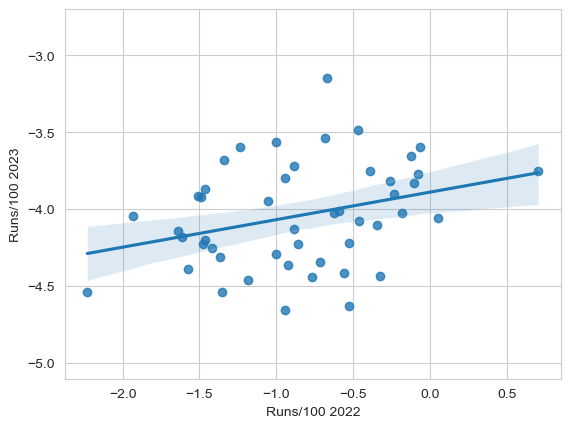

In [195]:
sns.regplot(x='Runs/100 2022', y='Runs/100 2023', data=framing23_qual)
plt.axis('equal')
plt.show()
